In [1]:
from dataloader import TraceDataset, PhonemeDataset
import torch
from models import trace, mnist
from torchviz import make_dot
import torch.nn.functional as F
import seaborn as sns
from matplotlib import pyplot as plt
from training import TraceTrainConfig, train_trace_model, evaluate_trace_model


## Computational graph plots

In [9]:
model

PCModel(
  (layers): Sequential(
    (input): InputLayer(shape=(20, 7))
    (phoneme_layer): MiddleLayer(in_shape=7, out_shape=128)
    (word_layer): MiddleLayer(in_shape=128, out_shape=200)
    (output): OutputLayer(in_shape=200, out_shape=200)
  )
)

In [7]:
batch = next(iter(dataloader))
words, features, labels_ind = batch.values()
labels = F.one_hot(labels_ind, num_classes=num_words).float().to(device)
features = features.to(device)

model.reset()

model.clamp(input_data=features[:, 0, :])
rec, loss_bw, layer_losses = model.backward()
out = model.forward(features[:, 0, :])
loss_fw = F.cross_entropy(out, labels)
loss = loss_fw + loss_bw
loss.backward()

NameError: name 'dataloader' is not defined

In [11]:
dot = make_dot(loss, params=dict(list(model.named_parameters()) + [('features', features), ('labels', labels)]))
dot.format = 'png'
dot.render('trace_single_step')

'trace_single_step.png'

## Training on TRACE

In [ ]:
config = TraceTrainConfig(test_split=0, epochs=50, noise=0, step=0.1, step_optimizer_per_phoneme=True)
result = train_trace_model(config=config)
model = result.model
history = result.history
train_dataloader = result.train_dataloader
val_dataloader = result.val_dataloader

losses = history["loss"]
losses_fw = history["loss_fw"]
losses_bw = history["loss_bw"]
gradients = history["grad_norm"]
accuracies = history["acc"]
val_accuracies = history["val_acc"]


Epoch 200/200 Loss: 2168.0642 Acc: 0.00, Val 0.00%: 100%|██████████| 1200/1200 [05:22<00:00,  3.72it/s]


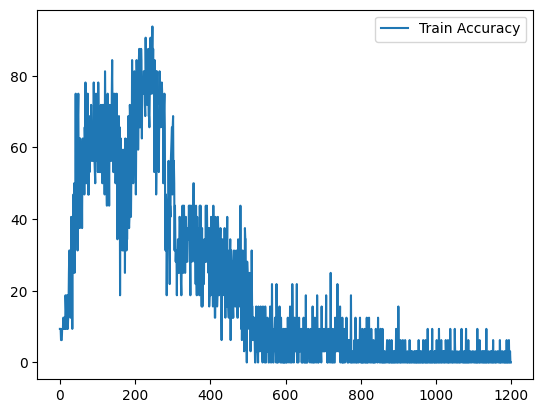

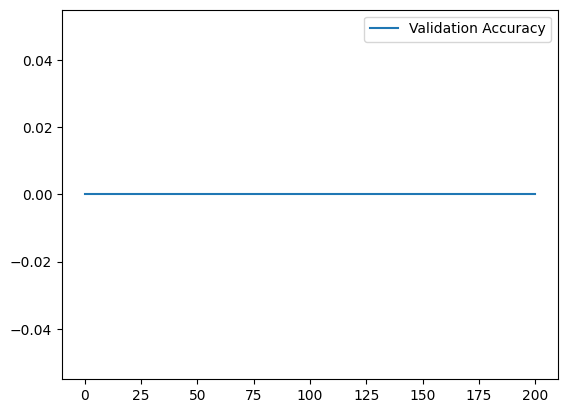

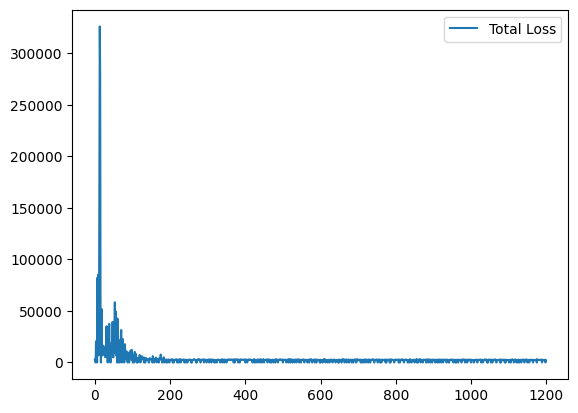

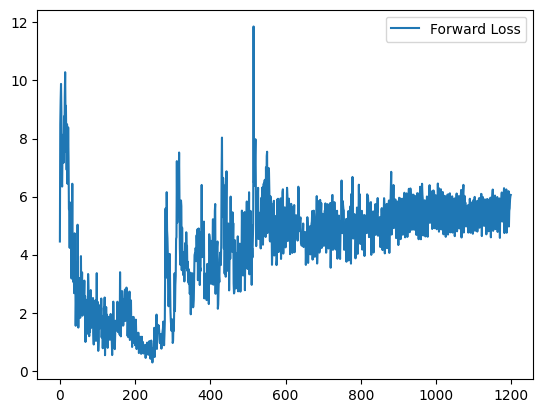

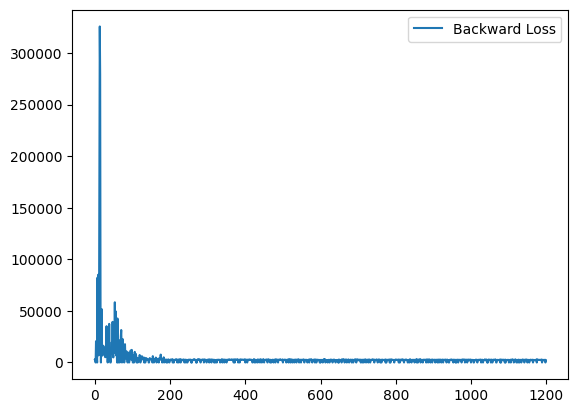

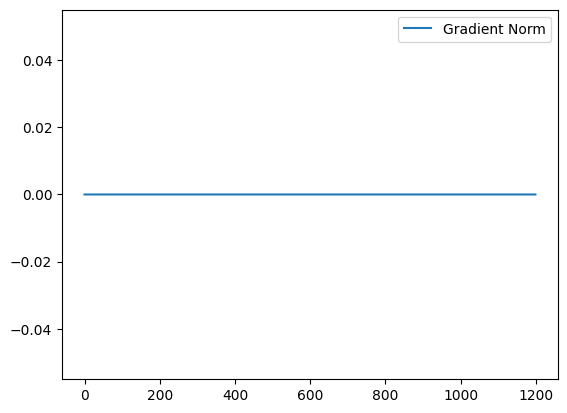

In [3]:
sns.lineplot(accuracies, label='Train Accuracy')
plt.show()
sns.lineplot(val_accuracies, label='Validation Accuracy')
plt.show()
sns.lineplot(losses, label='Total Loss')
plt.show()
sns.lineplot(losses_fw, label='Forward Loss')
plt.show()
sns.lineplot(losses_bw, label='Backward Loss')
plt.show()
sns.lineplot(gradients, label='Gradient Norm')
plt.show()

In [4]:
acc, predictions, original_words = evaluate_trace_model(model, train_dataloader, config)


In [5]:
for p, w in zip(predictions, original_words):
    pred_w = TraceDataset().words_padded[p.item()]
    if pred_w[:len(w)] != w:
        print(f"Predicted: {pred_w}, Original: {w}")

Predicted: dark-----, Original: krap
Predicted: dark-----, Original: kard
Predicted: dark-----, Original: parti
Predicted: dark-----, Original: bl^d
Predicted: bist-----, Original: but
Predicted: bist-----, Original: pap^
Predicted: dark-----, Original: l^kS^ri
Predicted: dark-----, Original: tar
Predicted: bist-----, Original: ^d^lt
Predicted: dark-----, Original: kap
Predicted: dark-----, Original: kalig
Predicted: bist-----, Original: strit
Predicted: bist-----, Original: slip
Predicted: bist-----, Original: tu
Predicted: bist-----, Original: dip
Predicted: bist-----, Original: Sut
Predicted: dark-----, Original: rut
Predicted: bist-----, Original: slit
Predicted: dark-----, Original: glu
Predicted: bist-----, Original: ^slip
Predicted: bist-----, Original: Sap
Predicted: dark-----, Original: strik
Predicted: dark-----, Original: r^b
Predicted: dark-----, Original: ^gli
Predicted: dark-----, Original: s^k
Predicted: dark-----, Original: blu
Predicted: bist-----, Original: stup^d
Pre